The **Costa Rican Household Poverty Level Prediction** Challenge

Data is available at https://www.kaggle.com/c/costa-rican-household-poverty-prediction/data (for registered users).

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import beta
from sklearn.metrics import f1_score, accuracy_score, classification_report, plot_confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns

sns.set(font_scale = 1.3)

def concat_null_indicator(s, fill_val=0.0):
    """For a Series s this function returns a DataFrame where the original Series
    is modified by imputing missing values with fill_val. Additionally a column
    with a binary indicator for the missing values is added."""
    mask = s.isnull()
    if mask.sum() > 0:
        cleaned = s.fillna(fill_val)
        indicator = mask * 1.0
        return pd.DataFrame({s.name: cleaned, s.name+'_nulls': indicator})
    else:
        return pd.DataFrame({s.name: s})

def handle_null_elements(df):
    """Missing values in a DataFrame df are filled and indicated by newly added columns"""
    data = None
    excluded_cols = ['dependency', 'idhogar']
    for c in [x for x in df.columns if x not in excluded_cols]:
        new_df = concat_null_indicator(df[c])
        if data is None:
            data = new_df
        else:
            data = pd.concat([data, new_df],axis=1)
    return data

def select_predictors_and_response(data, response_col, excluded_cols):
    """Function to split features and response variable from the DataFrame data."""
    pred_cols = [e for e in data.columns if e not in [response_col]]
    pred_cols = [e for e in pred_cols if e not in excluded_cols]
    return data[pred_cols].copy(), data[response_col] if response_col else None

def evaluation(y, predictions):
    """Prints evaluation of model performance. The relevant metric for this challenge is the
    F1 macro score."""
    acc = accuracy_score(y, predictions)
    print('Accuracy %.3f' % acc)
    f1 = f1_score(y, predictions, average='macro')
    print('F1 (macro): %.3f' % f1)
    print()
    print(classification_report(y,predictions))


raw_data = pd.read_csv('train.csv', index_col='Id')
test_data = pd.read_csv('test.csv', index_col='Id')
num_rows_file1 = len(raw_data)

raw_data = pd.concat([raw_data, test_data], sort=False)

In [2]:
raw_data.head()

,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
Id,,,,,,,,,,,,,,,,,,,,,
ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,1,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4.0
ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,1,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4.0
ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4.0
ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,2,...,81,289,16,121,4,1.777778,1.0,121.0,289,4.0
ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,2,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4.0


In [3]:
raw_data.Target.value_counts()

4.0    5996
2.0    1597
3.0    1209
1.0     755
Name: Target, dtype: int64

A `Target` value of 1 indicates extreme poverty, a value of 4 "non vulnerable households".

In [4]:
data = handle_null_elements(raw_data)
data = pd.get_dummies(data)

In [5]:
test_data = data[num_rows_file1:].copy()
test_idhogar = raw_data.idhogar[num_rows_file1:].copy()
data = data[:num_rows_file1].copy()
data_idhogar = raw_data.idhogar[:num_rows_file1].copy()

### Data Exploration
We look for features with the stronges correlation with `Target` and produce pair plots for the top 5 features.

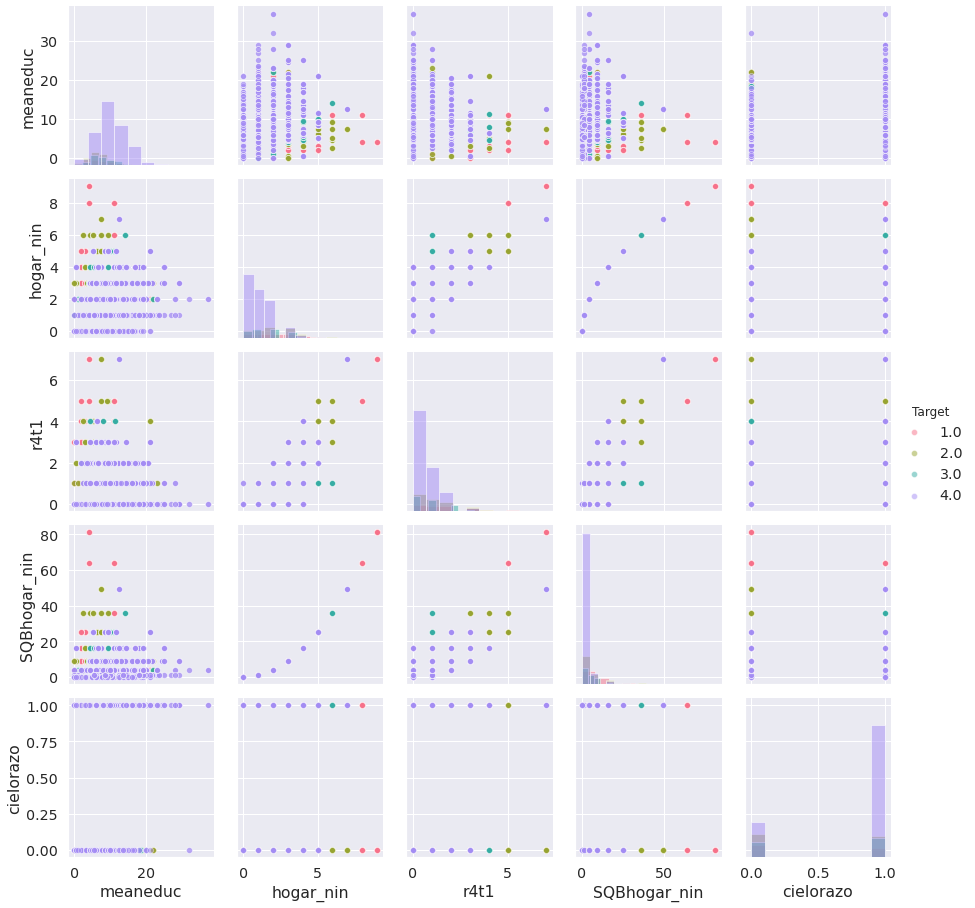

In [6]:
corrs = pd.Series(dtype=float)
for c in data.columns:
    corrs.loc[c] = np.abs(data[c].corr(data['Target']))
corrs = corrs.sort_values(ascending=False)
ax = sns.pairplot(data[[x for x in corrs[:6].index]], hue="Target", palette="husl", diag_kind='hist', plot_kws={'alpha': 0.5}, diag_kws={'alpha': 0.5})

### Model Building
Some signal is clearly visible in the plots but it's quite clear that linear methods will not get us very far. But before applying a tree-based approach we have to make sure that we model on a per-household level and not on an individual level. Furthermore, we use class weights which are inversely proportional to the support of the class to make sure that the model gets good accuracy for the lower-prevalence classes.

In [7]:
data_g = pd.concat([data_idhogar, data], axis=1)
data_g = data_g.groupby('idhogar').mean()

In [8]:
data_subset = data_g.sample(frac=1)
num_train = int(len(data_g)*8/10)
num_test = 0
num_val = int(len(data_g)*2/10)

data_train = data_subset.iloc[:num_train,:].copy()
data_test = data_subset.iloc[num_train:num_train+num_test,:].copy()
data_val = data_subset.iloc[num_train+num_test:,:].copy()
print(len(data_train.columns))
print(data_subset.shape, data_train.shape, data_test.shape, data_val.shape )


188
(2988, 188) (2390, 188) (0, 188) (598, 188)


In [9]:
special_cols = []
X, y = select_predictors_and_response(data_train, 'Target', special_cols)

In [10]:
y = y.astype(int)
w_map = (len(y) / y.value_counts()) ** 0.7
w_map = w_map.to_dict()
w = y.apply(lambda x: w_map[x])
w_map

{4: 1.3583834523691143,
 2: 3.7551171405495123,
 3: 4.335462153312737,
 1: 5.842082297201083}

In [11]:
params = {'n_estimators': 256, 'max_depth': 3, 'subsample': 0.8,
          'learning_rate': 0.01, 'min_samples_leaf': 1, 'random_state': 3,
          'warm_start': True, 'verbose': True
         }
clf = GradientBoostingClassifier(**params)

clf = clf.fit(X, y, sample_weight=w)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1        6259.4732           4.9106           19.71s
         2        6341.7668           3.6456           17.09s
         3        6220.8562           5.0421           16.71s
         4        6317.9854           3.6603           16.55s
         5        6225.7332           3.7627           16.11s
         6        6251.2642           4.2598           15.68s
         7        6137.8356           3.7555           15.66s
         8        6163.7051           2.7871           15.64s
         9        6223.3283           3.1808           15.48s
        10        6091.7650           2.9275           15.26s
        20        5986.1934           2.1499           14.00s
        30        5899.2248           2.9088           13.24s
        40        5677.8204           1.4405           12.58s
        50        5470.7495           1.5100           11.95s
        60        5539.5910           1.4987           11.34s
       

In [12]:
predictions = clf.predict(X)

Accuracy 0.735
F1 (macro): 0.630

              precision    recall  f1-score   support

           1       0.64      0.62      0.63       192
           2       0.51      0.68      0.58       361
           3       0.51      0.44      0.47       294
           4       0.86      0.82      0.84      1543

    accuracy                           0.74      2390
   macro avg       0.63      0.64      0.63      2390
weighted avg       0.75      0.74      0.74      2390



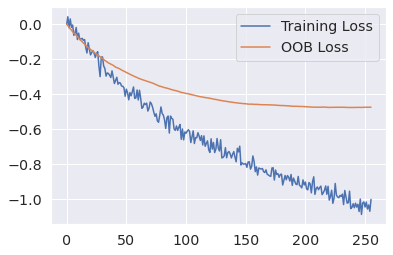

In [13]:
evaluation(y, predictions)

plt.plot(1.0/(0.8*len(y)) * (clf.train_score_-clf.train_score_[0]), label='Training Loss')
plt.plot(1.0/(0.2*len(y)) * (-np.cumsum(clf.oob_improvement_) + clf.oob_improvement_[0]), label='OOB Loss')
plt.legend(loc='upper right')
plt.show()

Validation Set

Accuracy 0.627
F1 (macro): 0.401

              precision    recall  f1-score   support

           1       0.22      0.16      0.19        50
           2       0.30      0.44      0.35        84
           3       0.25      0.26      0.26        61
           4       0.84      0.78      0.81       403

    accuracy                           0.63       598
   macro avg       0.40      0.41      0.40       598
weighted avg       0.65      0.63      0.64       598



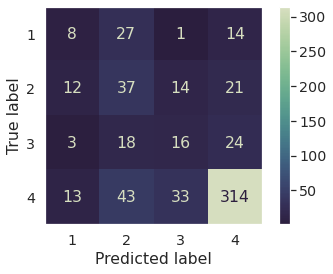

In [14]:
X_val, y_val = select_predictors_and_response(data_val, 'Target', special_cols)
y_val = y_val.astype(int)
pred_val = clf.predict(X_val)

print('Validation Set\n')
evaluation(y_val, pred_val)

ax = plot_confusion_matrix(clf, X_val, y_val, normalize=None, cmap=matplotlib.colors.ListedColormap(sns.cubehelix_palette(256, start=.5, rot=-.75, reverse=True)))
plt.grid(False)
plt.show()

### Inference

In [15]:
test_data.head()

,v2a1,v2a1_nulls,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,v18q1_nulls,...,edjefa_21,edjefa_3,edjefa_4,edjefa_5,edjefa_6,edjefa_7,edjefa_8,edjefa_9,edjefa_no,edjefa_yes
Id,,,,,,,,,,,,,,,,,,,,,
ID_2f6873615,0.0,1.0,0,5,0,1,1,0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
ID_1c78846d2,0.0,1.0,0,5,0,1,1,0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
ID_e5442cf6a,0.0,1.0,0,5,0,1,1,0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
ID_a8db26a79,0.0,1.0,0,14,0,1,1,1,1.0,0.0,...,0,0,0,0,0,0,0,0,1,0
ID_a62966799,175000.0,0.0,0,4,0,1,1,1,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
data_test_g = pd.concat([test_idhogar, test_data], axis=1)
data_test_g = data_test_g.groupby('idhogar').mean()

In [17]:
X_test, _ = select_predictors_and_response(data_test_g, 'Target', special_cols)

In [18]:
pred_test = clf.predict(X_test)

In [19]:
sub_households = pd.Series(pred_test, name='Target', index=data_test_g.index).reset_index()
sub_households

sub = pd.merge(test_idhogar.reset_index(), sub_households, how='outer')

In [20]:
sub.describe(include='all')

,Id,idhogar,Target
count,23856,23856,23856.000000
unique,23856,7352,NaN
top,ID_00a0d7ff2,8e9159699,NaN
freq,1,13,NaN
mean,NaN,NaN,3.217136
std,NaN,NaN,1.050062
min,NaN,NaN,1.000000
25%,NaN,NaN,2.000000
50%,NaN,NaN,4.000000
75%,NaN,NaN,4.000000


### Sanity Check
Check if class counts look plausible when compared to the training data.

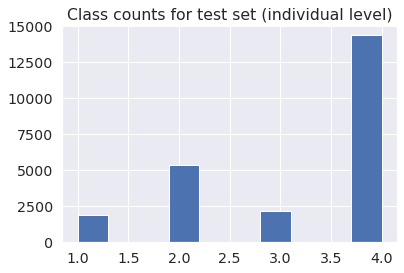

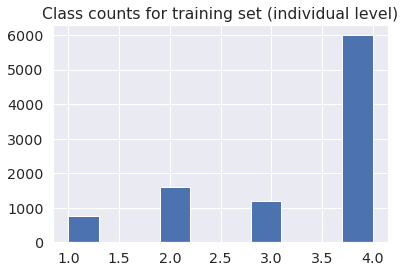

In [21]:
ax = sub.Target.hist()
plt.title('Class counts for test set (individual level)')
plt.show()

ax = data.Target.hist()
plt.title('Class counts for training set (individual level)')
plt.show()

LGTM, write predictions to disk

In [22]:
pd.DataFrame(sub[['Id','Target']]).to_csv('pred.csv', index=False)